# Simple Neural Implementation of Iterative MAP Calculation (WITH LEARNING)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Util functions
def g(v):
    return np.square(v)

def dg(v):
    return 2*v

In [13]:
class Task:
    def __init__(self, v_mean, v_var, u_var):
        self.v_mean = v_mean
        self.v_var = v_var
        self.u_var = u_var
    
    def sample(self):
        v = np.random.normal(self.v_mean, np.sqrt(self.v_var))
        u = np.random.normal(g(v), np.sqrt(self.u_var))
        return v, u

class Network:
    def __init__(self, min_sigma = 1.0, v_p=3, Sigma_p=1, Sigma_u=1):
        self.min_sigma = min_sigma
        # Network Parameters. Stored as lists to keep track of history
        self.v_p = [v_p]
        self.Sigma_p = [Sigma_p]
        self.Sigma_u = [Sigma_u]


    # Generates a new sample and resets activations
    def reset(self, u):
        self.u = u
        self.phi = self.v_p[-1]
        self.eps_u = 0
        self.eps_p = 0
        self.t = 0


    # Updates the state of the network by gradient ascent on F (no learning)
    def update(self, dt=0.01):
        # Calculate gradients
        dF_deps_p = self.phi - self.v_p[-1] - self.Sigma_p[-1] * self.eps_p
        dF_deps_u = self.u - g(self.phi) - self.Sigma_u[-1] * self.eps_u
        dF_dphi = self.eps_u * dg(self.phi) - self.eps_p

        # Perform gradient ascent
        self.eps_p += dt * dF_deps_p
        self.eps_u += dt * dF_deps_u
        self.phi += dt * dF_dphi

        self.t += dt


    # Learn parameters by gradient ascent on F. Call after network has converged
    def learn(self, lr=0.01):
        # Calculate gradients
        dFdv_p = np.tanh(self.eps_p)
        dFdSigma_p = np.tanh(0.5 * (self.eps_p * self.eps_p - 1/self.Sigma_p[-1]))
        dFdSigma_u = np.tanh(0.5 * (self.eps_u * self.eps_u - 1/self.Sigma_u[-1]))

        # Perform gradient ascent
        self.v_p.append(self.v_p[-1] + lr * dFdv_p)
        self.Sigma_p.append(self.Sigma_p[-1] + lr * dFdSigma_p)
        self.Sigma_u.append(self.Sigma_u[-1] + lr * dFdSigma_u)

        # Enforce minimum Sigma, per Friston 2005
        if self.min_sigma is not None:
            if self.Sigma_p[-1] < self.min_sigma:
                self.Sigma_p[-1] = self.min_sigma
            if self.Sigma_u[-1] < self.min_sigma:
                self.Sigma_u[-1] = self.min_sigma

        return dFdv_p, dFdSigma_p, dFdSigma_u # Return gradients for plotting


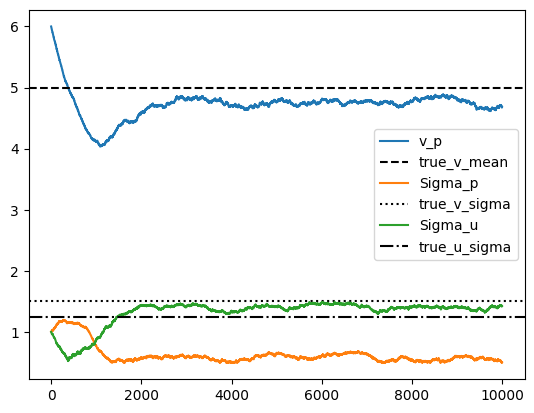

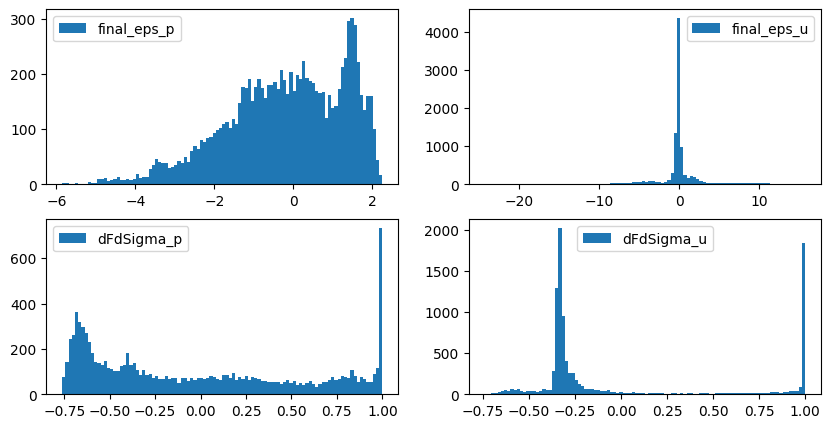

In [15]:
# True Statistics
v_mean = 5
v_var = 1.5
u_var = 1.25
task = Task(v_mean, v_var, u_var)

# Initialises network and tracking lists
network = Network(v_p=6, min_sigma=0.5) # Reduced min_sigma so we can see how it learns
final_eps_p = []
final_eps_u = []
grads_Sigma_p = []
grads_Sigma_u = []

for _ in range(10000):
    true_v, u = task.sample()
    network.reset(u)

    while network.t < 5:
        state = network.update()
    grads = network.learn(0.005)

    # Track statistics
    final_eps_p.append(network.eps_p)
    final_eps_u.append(network.eps_u)
    grads_Sigma_p.append(grads[1])
    grads_Sigma_u.append(grads[2])

plt.plot(network.v_p, label='v_p')
plt.axhline(v_mean, color='black', linestyle='--', label='true_v_mean')
plt.plot(network.Sigma_p, label='Sigma_p')
plt.axhline(v_var, color='black', linestyle=':', label='true_v_sigma')
plt.plot(network.Sigma_u, label='Sigma_u')
plt.axhline(u_var, color='black', linestyle='-.', label='true_u_sigma')
plt.legend()
plt.show()

fig, axs = plt.subplots(2, 2, figsize=(10, 5))
axs[0,0].hist(final_eps_p, bins=100, label='final_eps_p')
axs[0,0].legend()
axs[0,1].hist(final_eps_u, bins=100, label='final_eps_u')
axs[0,1].legend()
axs[1,0].hist(grads_Sigma_p, bins=100, label='dFdSigma_p')
axs[1,0].legend()
axs[1,1].hist(grads_Sigma_u, bins=100, label='dFdSigma_u')
axs[1,1].legend()

plt.show()

In [12]:
print('grads_Sigma_p mean & var: ', np.mean(grads_Sigma_p), np.var(grads_Sigma_p))
print('grads_Sigma_u mean & var: ', np.mean(grads_Sigma_u), np.var(grads_Sigma_u))

grads_Sigma_p mean & var:  0.12371070211156694 0.41242494829418175
grads_Sigma_u mean & var:  0.3392184015228738 64.54952182113584
